In [85]:
"""
  INFORMATION:
  
    Course     : EEE485/585
    Name       : Can Kocagil
    ID         : 21602218
    E-mail     : can.kocagil@ug.bilkent.edu.tr
    Assignment : Progress Report

"""

from __future__ import (
    print_function,
    division
)

import matplotlib.pyplot as plt
import stopwordsiso as swiso
import seaborn as sns
import pandas as pd
import numpy as np
import cleantext
import warnings
import random
import string
import pickle
import spacy
import json
import nltk
import time
import abc
import os 
import re
import sys 
sys.path.append('./src')

from sklearn.utils.validation import (
    check_X_y, 
    check_array
)

from typing import (
    Callable,
    Iterable,
    List,
    Union,
    Tuple,
)

from utils import (
    Pipeline,
    Classifier,
    json_print,
    timeit,
    random_seed,
)

from classifier import (
    KNeighborsClassifier,
    MultiNominalNaiveBayes,
    BernaulliNaiveBayes,
    LogisticRegression
)

from feature import (
    BackwardElimination,
    #mutual_information
)

from metrics import (
    precision_score,
    recall_score,
    fbeta_score,
    confusion_matrix
)

In [46]:
df = pd.read_parquet('../data/final_training_data.parquet')

df = df.sample(1000)

In [47]:
def train_test_split(X:pd.DataFrame, split_size:list = [0.7, 0.1, 0.2], random_state:int = 42):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X.copy())

    split_size = np.array(split_size)

    assert np.isclose(split_size.sum(), 1.0), f"Split ratios should sum to 1"

    cum_splits = split_size.cumsum()
    len_X = len(X)

    indices = np.ceil(cum_splits[:2] * len_X)

    train, val, test = np.split(
        X.sample(frac = 1, random_state = random_state),
        indices.astype(np.int)
    )
    
    if test.shape[0] == 0:
        return train, val
        
    return train, val, test


In [48]:
def save_obj(obj: object, path: str = None) -> None:
    """ Saves Python Object as pickle"""
    with open(path + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path: str = None) -> object:
    """ Loads Python Object from pickle"""
    with open(path + '.pkl', 'rb') as f:
        return pickle.load(f)

In [49]:
def get_embedding(path: str = 'glove.6B.50d.txt', save_path: str = '../word_embeddings/love.6B.50d') -> dict:
    """ Given the path of the embedding file, return a dictionary of embedding"""
    
    assert os.path.exists(save_path), f"The path {path} is not exists"

    embeddings_index = {}
    f = open('glove.6B.50d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    if save_path:
        save_obj(embeddings_index, save_path)

    return embeddings_index

def max_token_size(text):
    return np.max(
    text.apply(
        lambda doc: len(doc.split())
    )
)

def zero_padding(doc, max_length=12):
    doc = doc.split()
    if len(doc) < max_length:
        length_doc = len(doc)
        num_expand = max_length - length_doc
        doc.extend(['0'] * num_expand)
    return " ".join(doc)

def zero_padding_transformer(text, max_length):
    return text.apply(
        lambda doc: zero_padding(
            doc, 
            max_length = max_length
        )
    )

In [50]:
class PretrainedWord2Vec:
    def __init__(self, embeddings_index, max_length):
        self.max_length = max_length
        self.embeddings_index = embeddings_index

    def doc_to_vec(self, doc):
        return np.array([
            self.embeddings_index[token] if token in self.embeddings_index.keys() else self.embeddings_index['unknown'] for token in doc.split()
        ])

    def fit(self, df:pd.DataFrame) -> None:
        if not isinstance(df, pd.Series):
            df = pd.Series(df.copy())

        self.vectors = df.apply(
            self.zero_padding
        ).apply(
            self.doc_to_vec
        )

        return self
        
    def transform(self, df):
        return np.array(
            self.vectors.tolist(), 
            dtype=np.float
        )

    def zero_padding(self, doc):
        doc = doc.split()
        if len(doc) < self.max_length:
            length_doc = len(doc)
            num_expand = self.max_length - length_doc
            doc.extend(['0'] * num_expand)
        return " ".join(doc)

class EmbeddingAggregator:
    def __init__(self, mode='mean'):
        self.mode = mode
    
    def transform(self, embedding):
        if self.mode == 'mean':
            agg_embed = np.mean(embedding, axis=1)

        elif self.mode == 'sum':
            agg_embed = np.sum(embedding, axis=1)

        elif self.mode == 'median':
            agg_embed = np.median(embedding, axis=1)

        elif self.mode == 'max':
            agg_embed = np.max(embedding, axis=1)

        elif self.mode == 'min':
            agg_embed = np.min(embedding, axis=1)

        else:
            raise ValueError(f"Unknown mode {self.mode}")
    
        return agg_embed

class SimplePipeline:
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def run(self, X):
        out = X.copy()
        for pipe in self.pipeline:
            out = pipe(out)
        return out

In [51]:
embeddings_index = load_obj(
    os.path.join(
        os.getcwd(), 
        '../word_embeddings/love.6B.50d'
    )
)

In [52]:
train_set, val_set, test_set = train_test_split(
    df, 
    split_size = [0.7, 0.1, 0.2],
    random_state=51
)

In [53]:
training_texts = train_set['clean_freq_removed_text']
validation_texts = val_set['clean_freq_removed_text']

In [54]:
max_token_num = max_token_size(training_texts)

embedding_transformer = PretrainedWord2Vec(
    embeddings_index,
    max_token_num
)
embed_aggregator = EmbeddingAggregator()

embedding_transformer.fit(training_texts)
training_vectors = embedding_transformer.transform(training_texts)

X_train = embed_aggregator.transform(training_vectors)

In [55]:
embedding_transformer.fit(validation_texts)

val_vectors = embedding_transformer.transform(validation_texts)

X_val = embed_aggregator.transform(val_vectors)

In [56]:
y_train = train_set['sentiment']
y_val = val_set['sentiment']

In [57]:
X_train  = pd.DataFrame(X_train)
X_val  = pd.DataFrame(X_val)
y_train = pd.DataFrame(y_train)
y_train.columns = ['class']

In [58]:
X_train.shape, X_val.shape, y_train.shape

((700, 50), (100, 50), (700, 1))

In [63]:
distances = [
    'euclidean',
    'manhattan',
    'cosine'
]

k_neighbors = np.arange(1, 17, 2)

cache_model = []

for distance in distances:
    for k_neighbor in k_neighbors:
        pipe = Pipeline([
            ('classifier', 
            KNeighborsClassifier(
                k_neighbors = k_neighbor,
                distance_metric = distance
                )
            )
        ])

        pipe.fit(
            X_train = X_train.values,
            y_train = y_train.values
        )

        score = pipe.score(
            X_test = X_val.values,
            y_test = y_val.values
        )


        cache_model.append(
            (   
                pipe.model.k_neighbors,
                pipe.model.distance_metric, 
                score['accuracy']
            )
        )

result_df = pd.DataFrame(
    cache_model,
    columns = [
        'K-neighbors',
        'Distance',
        'Accuracy'
    ]
).sort_values(
    by = ['Accuracy', 'Distance'], 
    ascending=False
)

In [64]:
result_df

,K-neighbors,Distance,Accuracy
14,13,manhattan,50.48
10,5,manhattan,50.16
15,15,manhattan,50.16
2,5,euclidean,50.16
6,13,euclidean,50.16
9,3,manhattan,50.08
1,3,euclidean,50.08
3,7,euclidean,50.08
18,5,cosine,50.08
13,11,manhattan,50.00


Time Consumed for fit: 0.5779 s
 with hyperparameters {}


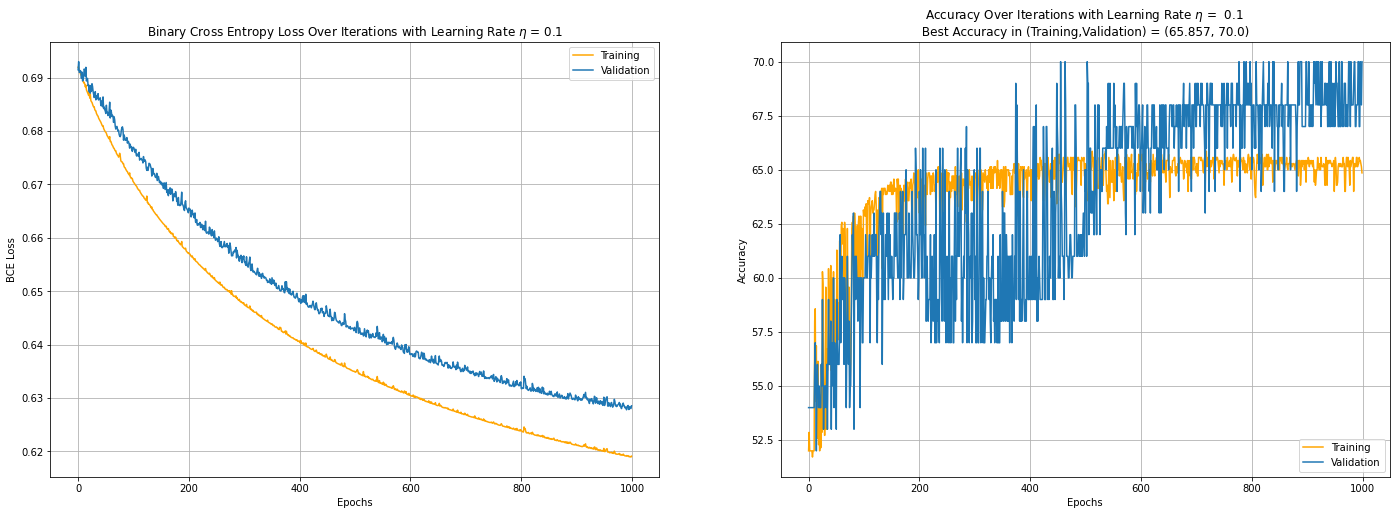

In [69]:
init_modes = ['zero', 'xavier', 'gauss']
learning_rates = np.arange(0, 1, 1e-5)
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
num_epochs = [100, 500, 1000, 2000,  3000, 4000, 5000, 6000, 7000]


train_config = dict(
    lr          = 1e-1,
    batch_size  = 64,
    epochs      = 1000,
    verbose = False,
)

model = LogisticRegression(init_mode='gauss')
model.fit(
    X_train.values,
    y_train.values.reshape(-1, 1),
    X_val.values,
    y_val.values.reshape(-1, 1),
    **train_config
)
model.plot_history()
print(model)

In [95]:
init_modes = [
    'zero', 
    'xavier', 
    'gauss'
]

learning_rates = np.random.choice(
    np.arange(0, 1, 1e-5), 
    size = 10, 
    replace=False
)

batch_sizes = [4, 8, 16, 32, 64, 128, 256]
num_epochs = [100, 500, 1000, 2000]


cache_model = []

for init_mode in init_modes:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for num_epoch in num_epochs:

                model = LogisticRegression(init_mode=init_mode)
                
                model.fit(
                    X_train.values,
                    y_train.values.reshape(-1, 1),
                    X_val.values,
                    y_val.values.reshape(-1, 1),
                    **dict(
                        lr          = learning_rate,
                        batch_size  = batch_size,
                        epochs      = num_epoch,
                        verbose = False,
                    )
                )

                cache_model.append(
                    (   
                        model.init_mode,
                        model.lr,
                        model.batch_size,
                        model.epochs,
                        model.history['val']['acc'][-1]
                    )
                )

result_df = pd.DataFrame(
    cache_model,
    columns = [
        'Init Mode',
        'Learning Rate',
        'Batch Size',
        '# of Epochs',
        'Accuracy'
    ]

).sort_values(
    by = ['Accuracy', 'Init Mode'], 
    ascending=False
)

result_df.to_csv('../results/LogisticRegressionHyperParamSearch.csv')

Time Consumed for fit: 0.6152 s
Time Consumed for fit: 3.1755 s
Time Consumed for fit: 6.2498 s
Time Consumed for fit: 12.2073 s
Time Consumed for fit: 0.3172 s
Time Consumed for fit: 1.5867 s
Time Consumed for fit: 3.2845 s
Time Consumed for fit: 6.4081 s
Time Consumed for fit: 0.1695 s
Time Consumed for fit: 0.8613 s
Time Consumed for fit: 1.7206 s
Time Consumed for fit: 3.4087 s
Time Consumed for fit: 0.0951 s
Time Consumed for fit: 0.4921 s
Time Consumed for fit: 0.9866 s
Time Consumed for fit: 1.9398 s
Time Consumed for fit: 0.0649 s
Time Consumed for fit: 0.3145 s
Time Consumed for fit: 0.6197 s
Time Consumed for fit: 1.2185 s
Time Consumed for fit: 0.0508 s
Time Consumed for fit: 0.2291 s
Time Consumed for fit: 0.4735 s
Time Consumed for fit: 0.8926 s
Time Consumed for fit: 0.0438 s
Time Consumed for fit: 0.2061 s
Time Consumed for fit: 0.4547 s
Time Consumed for fit: 0.8176 s
Time Consumed for fit: 0.6081 s
Time Consumed for fit: 3.0408 s
Time Consumed for fit: 6.27 s
Time Cons

In [96]:
result_df

,Init Mode,Learning Rate,Batch Size,# of Epochs,Accuracy
83,zero,0.45595,256,2000,70.0
139,zero,0.41642,256,2000,70.0
194,zero,0.78533,256,1000,70.0
225,zero,0.01342,4,500,70.0
419,xavier,0.41642,256,2000,70.0
...,...,...,...,...,...
809,gauss,0.01342,256,500,54.0
250,zero,0.01342,256,1000,53.0
796,gauss,0.01342,32,100,53.0
805,gauss,0.01342,128,500,53.0


fa